In [24]:
from PIL import Image
from pathlib import Path
import json
import imagehash
from bitarray import bitarray
import numpy as np
import tqdm
import matplotlib.pyplot as plt

## db

In [25]:
json_path ='../../backend/flask-app/storage/records.json'
with open(json_path) as f:
    db_data = json.load(f)
res = []
for o in db_data:
    res.append((o['object_id'],
                bitarray(o['aHash']),
                bitarray(o['pHash']),
                bitarray(o['dHash']),
                bitarray(o['wHash'])))
object_id, ahash, phash, dhash, whash = zip(*res)
db = {
    'object_id': object_id,
    'ahash': ahash,
    'phash': phash,
    'dhash': dhash,
    'whash': whash,
}

## pic

In [26]:
PIC_PATH = Path('../dataset/testing_images/')

In [27]:
true_map_path = '../annotation/true_map.csv'
with open(true_map_path) as f:
    true_map_raw = f.read()
true_map = [o.split(',') for o in true_map_raw.split('\n')]
name, object_id = zip(*true_map)
pic = {
    'name': name,
    'object_id': object_id,
}

In [28]:
crop_path = Path('../flask-app/crop.json')
with crop_path.open() as f:
    crop_lines = [json.loads(line) for line in f.readlines()]
for line in crop_lines:
    line['crop'] = json.loads(line['crop'])

In [29]:
dic = {name: i for i,name in enumerate(pic['name'])}
crops = [None] * len(pic['name'])
for line in crop_lines:
    name = line['image']
    i = dic[name]
    crops[i] = line['crop']
pic['crops'] = crops

## test crop

In [30]:
 # (left, upper, right, lower)-tuple.
def to_box(image, crop):
    width, height = image.size
    x, y, w, h = crop['x']/100, crop['y']/100, crop['width']/100, crop['height']/100
    x1 = int(x * width)
    y1 = int(y * height)
    x2 = int((x + w) * width) - 1
    y2 = int((y + h) * height) - 1
    return (x1, y1, x2, y2)

In [31]:
def get_matched_index(i, hfunc, nfunc, level):
    name = pic['name'][i]
    image_path = PIC_PATH / name
    image = Image.open(image_path)
    crop = pic[level][i]
    target_id = pic['object_id'][i]
    #
    c_image = image.crop(to_box(image, crop))
    c_image.load()
    raw_hash = ''.join(list(hfunc(c_image).hash.flatten().astype(int).astype(str)))
    h = bitarray(raw_hash)
    #
    idx = np.argsort([(h ^ h1).count(1) for h1 in db[nfunc]])
    matched = [db['object_id'][i] for i in idx]
    return matched.index(target_id), matched

In [32]:
for i, crop in enumerate(pic['crops']):
    if crop is None:
        print(i)

In [33]:
hfunc = imagehash.phash; nfunc = 'phash'
midx = []; marray = []
for i in tqdm.tqdm(list(range(len(pic['name'])))):
    mi, ma = get_matched_index(i, hfunc, nfunc, 'crops')
    midx.append(mi)
    marray.append(ma)
midx = np.array(midx)
marray = np.array(marray)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00,  3.31it/s]


In [34]:
print(np.sum(midx==0), np.sum(midx<5), np.sum(midx<10))

85 92 93


IMG_8463.JPG


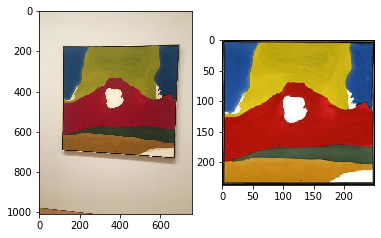

IMG_8524.JPG


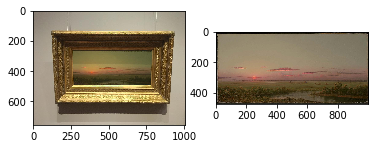

IMG_8567.JPG


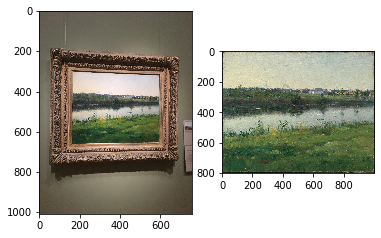

IMG_8571.JPG


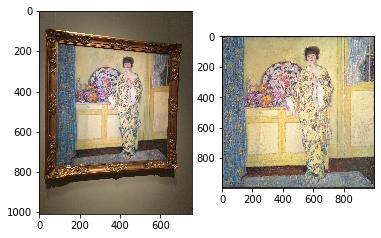

IMG_8579.JPG


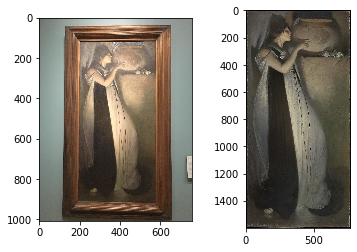

IMG_8616.JPG


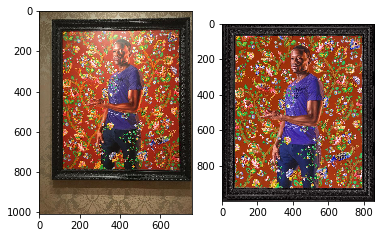

IMG_8624.JPG


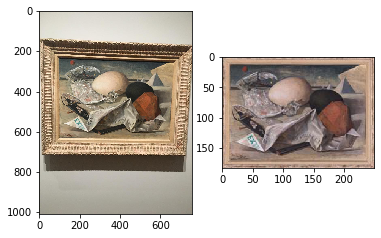

IMG_8652.JPG


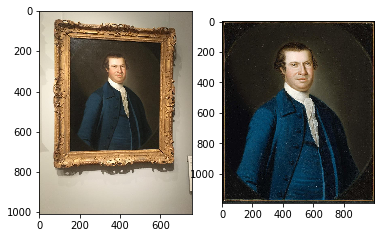

IMG_8666.JPG


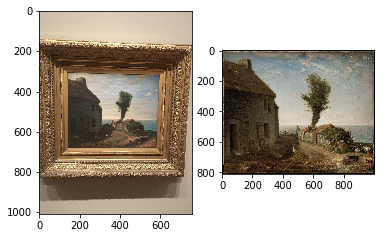

IMG_20191102_110938.jpg


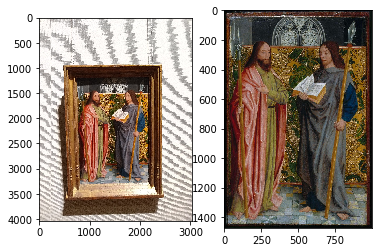

IMG_20191102_111333.jpg


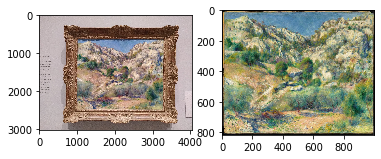

IMG_20191102_111241.jpg


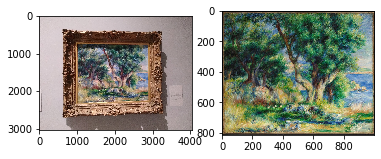

IMG_20191102_112048.jpg


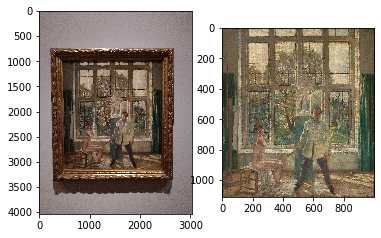

IMG_20191102_105219.jpg


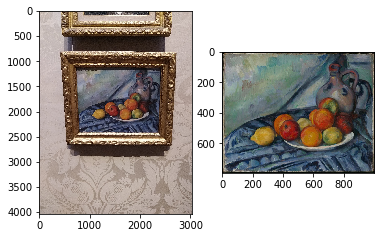

IMG_20191102_103834.jpg


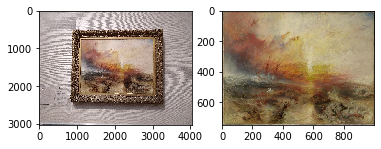

In [35]:
TRUE_PATH = Path('../../backend/flask-app/storage/images')
for i in range(len(midx)):
    if midx[i] != 0:
        fig = plt.figure()
        name = pic['name'][i]
        print(name)
        image_path = PIC_PATH / name
        image = Image.open(image_path)
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image))
        #
        object_id = pic['object_id'][i]
        true_path = TRUE_PATH / (object_id + '.jpg')
        image_true = Image.open(true_path)
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(image_true))
        plt.show()